## Strategy Definition

Now that we have learned how to access and manipulate data in Quantopian, let's construct a data pipeline for our long-short equity strategy. In general, long-short equity strategies consist of modeling the relative value of assets with respect to each other, and placing bets on the sets of assets that we are confident will increase ([long](https://www.investopedia.com/terms/l/long.asp)) and decrease ([short](https://www.investopedia.com/terms/s/short.asp)) the most in value.  

Long-short equity strategies profit as the spread in returns between the sets of high and low value assets increases. The quality of long-short equity strategy relies entirely on the quality of its underling ranking model. In this tutorial we will use a simple ranking schema for our strategy:  

**Strategy**: We will consider assets with a high 3 day average sentiment score as high value, and assets with a low 3 day average sentiment score as low value.

## Strategy Analysis

We can define the strategy above using `SimpleMovingAverage` and `stocktwits`'s `bull_minus_bear` data, similar to the pipeline we created in the previous lesson:

In [1]:
# Pipeline imports
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.filters import QTradableStocksUS


# Pipeline definition
def  make_pipeline():

    base_universe = QTradableStocksUS()

    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )

    return Pipeline(
        columns={
            'sentiment_score': sentiment_score,
        },
        screen=base_universe
    )

For simplicity, we will only analyze the top 350 and bottom 350 stocks ranked by `sentiment_score`. We can create pipeline filters for these sets using the `top` and `bottom` methods of our `sentiment_score` output, and combine them using the `|` operator to get their union. Then, we will remove anything outside of our tradable universe by using the `&` operator to get the intersection between our filter and our universe:

In [2]:
# Pipeline imports
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.filters import QTradableStocksUS

# Pipeline definition
def  make_pipeline():

    base_universe = QTradableStocksUS()

    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )

    # Create filter for top 350 and bottom 350
    # assets based on their sentiment scores
    top_bottom_scores = (
        sentiment_score.top(350) | sentiment_score.bottom(350)
    )

    return Pipeline(
        columns={
            'sentiment_score': sentiment_score,
        },
        # Set screen as the intersection between our filter
        # and trading universe
        screen=(
            base_universe
            & top_bottom_scores
        )
    )

Next, let's run our pipeline over a 3 year period to get an output we can use for our analysis. This will take ~1 minute.

In [5]:
# Import run_pipeline method
from quantopian.research import run_pipeline

# Specify a time range to evaluate
period_start = '2016-01-01'
period_end = '2019-01-01'

# Execute pipeline over evaluation period
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date=period_start,
    end_date=period_end
)

In addition to sentiment data, we will need pricing data for all assets present in this period. We can easily get a list of these assets from our pipeline output's index, and pass that list to `prices` to get the pricing data we need:

In [6]:
# Import prices function
from quantopian.research import prices

# Get list of unique assets from the pipeline output
asset_list = pipeline_output.index.levels[1].unique()

# Query pricing data for all assets present during
# evaluation period
asset_prices = prices(
    asset_list,
    start=period_start,
    end=period_end
)

Now we can use Quantopian's open source factor analysis tool, [Alphalens](https://www.quantopian.com/lectures/factor-analysis-with-alphalens), to test the quality of our selection strategy. First, let's combine our factor and pricing data using get_clean_factor_and_forward_returns. This function classifies our factor data into quantiles and computes forward returns for each security for multiple holding periods. We will separate our factor data into 2 quantiles (the top and bottom half), and use 1, 5 and 10 day holding periods:

In [7]:
# Import Alphalens
import alphalens as al

# Get asset forward returns and quantile classification
# based on sentiment scores
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['sentiment_score'],
    prices=asset_prices,
    quantiles=2,
    periods=(1,5,10),
)

# Display first 5 rows
factor_data.head(5)

Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        5D       10D  \
date                      asset                                              
2016-01-04 00:00:00+00:00 Equity(53 [ABMD])  -0.001996 -0.001879  0.012330   
                          Equity(110 [RAMP]) -0.007459 -0.062158 -0.095475   
                          Equity(353 [AME])  -0.005313 -0.084713 -0.099333   
                          Equity(465 [APH])  -0.010812 -0.090621 -0.107900   
                          Equity(474 [APOG])  0.010100 -0.072652 -0.111905   

                                                factor  factor_quantile  
date                      asset                                          
2016-01-04 00:00:00+00:00 Equity(53 [ABMD])   2.273333                2  
                          Equity(110 [RAMP])  2.230000                2  
                          Equity(353 [AME])   2.300000                2  
                          Equity(465 [APH])  -1.256667                1  
                          Equity(474 [APOG]) -3.100000                1

Having our data in this format allows us to use several of Alphalens's analysis and plotting tools. Let's start by looking at the mean returns by quantile over the entire period. Because our goal is to build a long-short strategy, we want to see the lower quantile (1) have negative returns and the upper quantile(2) have positive returns:

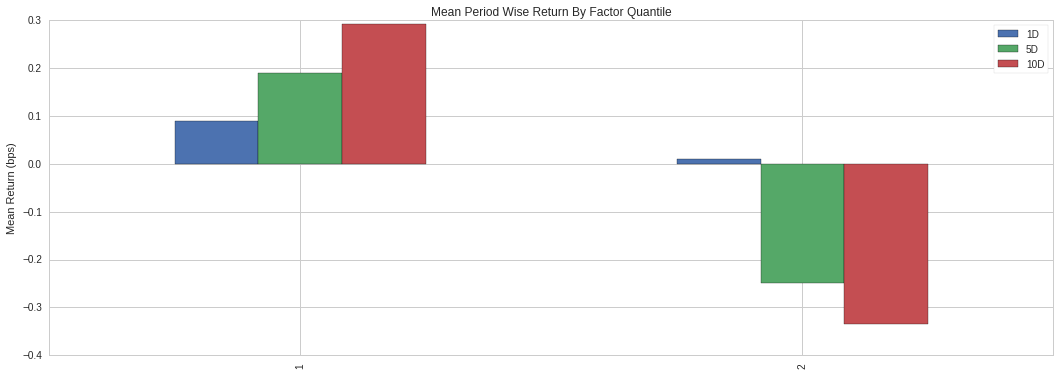

In [8]:
# Calculate mean return by factor quantile
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data)

# Plot mean returns by quantile and holding period
# over evaluation time range
al.plotting.plot_quantile_returns_bar(
    mean_return_by_q.apply(
        al.utils.rate_of_return,
        axis=0,
        args=('1D',)
    )
);

We can also plot the cumulative returns of a factor-weighted long-short portfolio with a 5 day holding period using the following code:

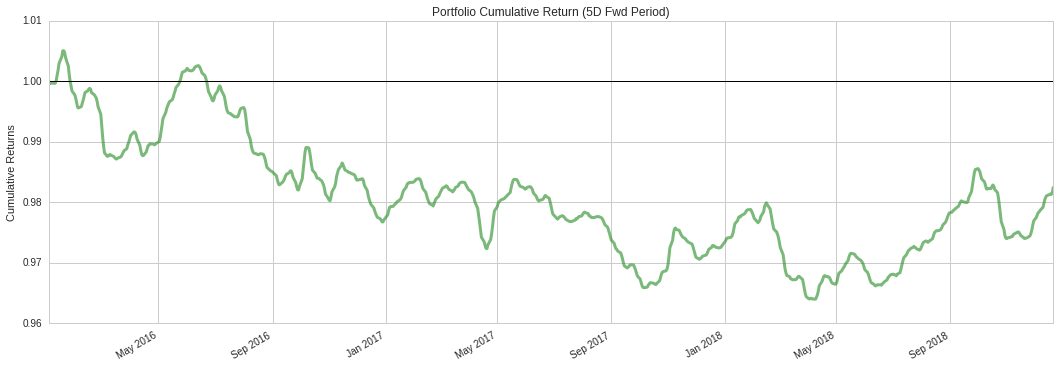

In [9]:
import pandas as pd
# Calculate factor-weighted long-short portfolio returns
ls_factor_returns = al.performance.factor_returns(factor_data)

# Plot cumulative returns for 5 day holding period
al.plotting.plot_cumulative_returns(ls_factor_returns['5D'], '5D', freq=pd.tseries.offsets.BDay());

The plot above shows a large drawdown period, and this analysis does not yet take into account transaction costs or market impact. It is not a very promising strategy. At this point we really should conduct a deeper analysis using Alphalens and then iterate on our strategy idea. But for the sake of this tutorial, let's continue with our strategy as it is.  

Having defined and tested a strategy, let's use it to build and test a long-short equity algorithm. The rest of the tutorial will cover the Algorithm API and will take place in the Interactive Development Environment (IDE).